## Keras Timeseries

## 1. Boston Housing Price

In [1]:
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [6]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [7]:
# prep data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [8]:
from keras import models
from keras import layers

In [12]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [ ]:
# K-fold cv
import numpy as np

k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores=[]

for i in range(k):
    print("처리중인 폴드 : ", i)
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1,
             verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [23]:
# save val score from each fold

num_epochs = 500
all_mae_histories=[]

for i in range(k):
    print("처리중인 폴드 #", k)
    
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1) * num_val_samples : ]], axis=0)
    
    model=build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 4
처리중인 폴드 # 4
처리중인 폴드 # 4
처리중인 폴드 # 4


In [24]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

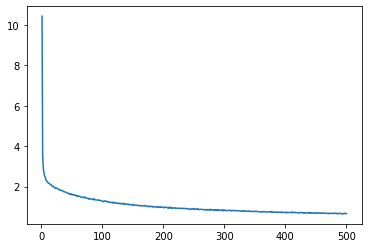

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

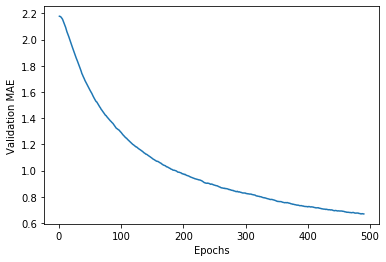

In [27]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score= model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 736us/step


In [29]:
test_mae_score

2.77738618850708

## 2. Electric Power Consumption

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [33]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [34]:
# import dataset
df = pd.read_csv('./datasets/power_cconsumption/household_power_consumption.txt', delimiter=';')
print('Number of Rows and Columns: ', df.shape)
df.head(5)

Number of Rows and Columns:  (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.globalactivepower: household global minute-averaged active power (in kilowatt)

4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [35]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [37]:
print(df['Sub_metering_3'].isnull().sum() / df.shape[0])

0.012518437457686004


In [38]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df = df.dropna(subset=['Global_active_power'])
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].apply(lambda x : x.year)
df['quarter'] = df['date_time'].apply(lambda x : x.quarter)
df['month'] = df['date_time'].apply(lambda x : x.month)
df['day'] = df['date_time'].apply(lambda x : x.day)
df = df.loc[:, ['date_time', 'Global_active_power', 'year', 'quarter', 'month', 'day']]

df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df['weekday'] = df.apply(lambda row: row['date_time'].weekday(), axis=1)
df['weekday'] = (df['weekday'] < 5).astype(int)

print('Number of rows and columns after removing missing values: ', df.shape)
print('The Time series starts from: ', df.date_time.min())
print('The Time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values:  (2049280, 7)
The Time series starts from:  2006-12-16 17:24:00
The Time series ends on:  2010-12-11 23:59:00


#### 결측치 제거 후 남은 데이터 2,049,280  

### Statistical Normality Test  
* p <= alpha : reject H0, not normal  
* p > alpha : fail to reject HO, normal

In [39]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f ' % (stat, p))
alpha = 0.05

if p>alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000 
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 4.218671866132129
Skewness of normal distribution: 1.7862320846320843


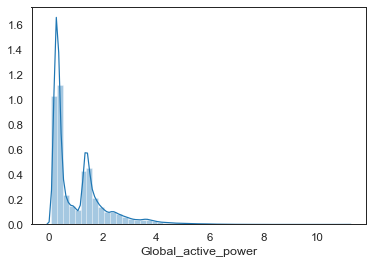

In [40]:
# calculate Kurtosis and Skewness

sns.distplot(df.Global_active_power)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

* Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.
* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time Series Plot

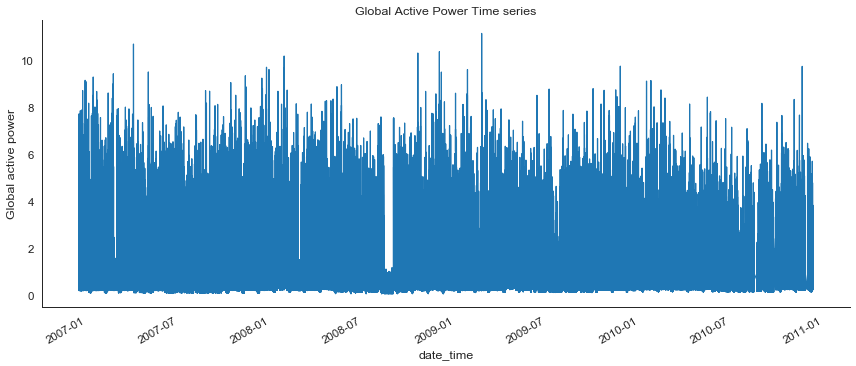

In [42]:
df1 = df.loc[:, ['date_time', 'Global_active_power']]
df1.set_index('date_time', inplace=True)
df1.plot(figsize=(12, 5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time series')
sns.despine(top=True)
plt.show()

#### 보이는게 없다...

### Box Plot of Yearly vs. Quarterly Global Active Power

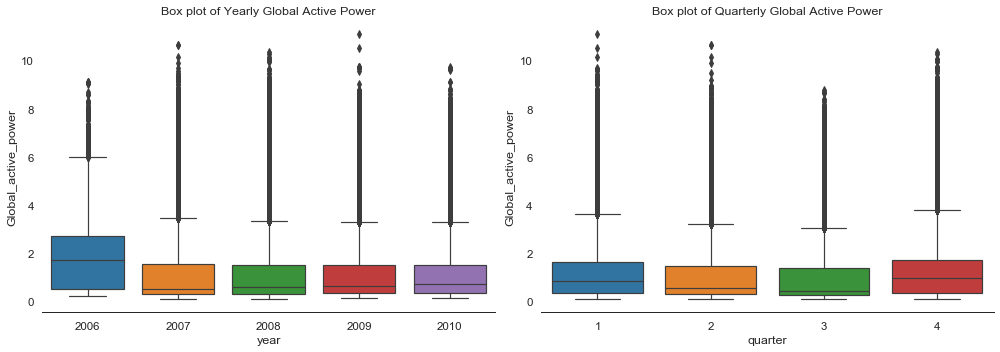

In [43]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power', data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x='quarter', y='Global_active_power', data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

This is consistent with the quarterly median global active power, it is higher in the 1st and 4th quarters (winter), and it is the lowest in the 3rd quarter (summer).

### Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


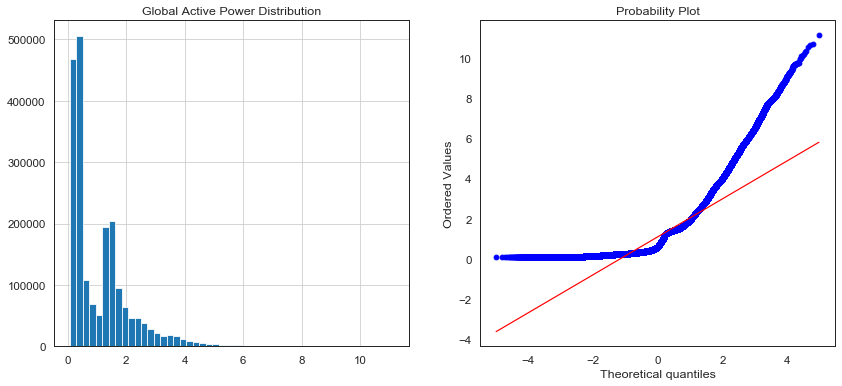

In [44]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1, 2, 2)
stats.probplot(df['Global_active_power'], plot=plt)
df1.describe().T

Normal probability plot also shows the data is far from normally distributed.

### Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

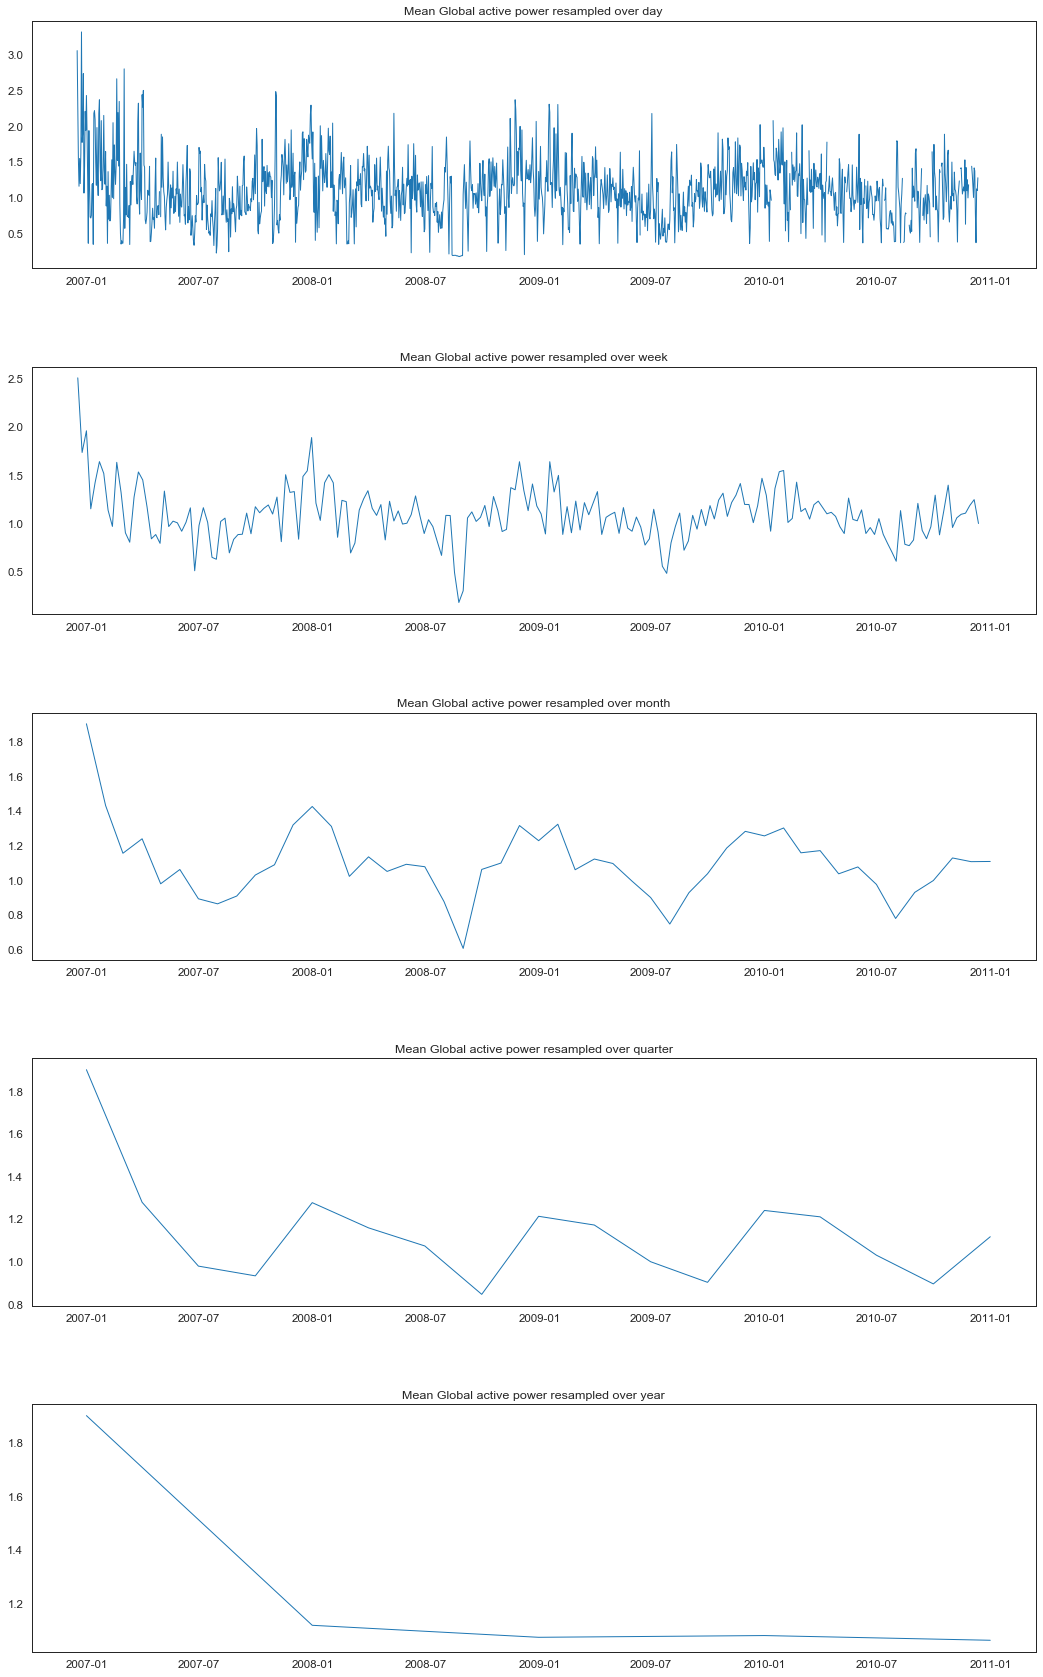

In [47]:
fig = plt.figure(figsize=(18, 30))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5, 1, 1)
ax1.plot(df1['Global_active_power'].resample('D').mean(), linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2=fig.add_subplot(5, 1, 2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(), linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3=fig.add_subplot(5, 1, 3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(), linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4=fig.add_subplot(5, 1, 4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(), linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5=fig.add_subplot(5, 1, 5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(), linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major')

The highest average power consumption seems to be prior to 2007, actually it was because we had only December data in 2007 and that month was a high consumption month. In another word, if we compare year by year, it has been steady.

### Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day

Text(0.5, 1.0, 'Mean Global active power by Day')

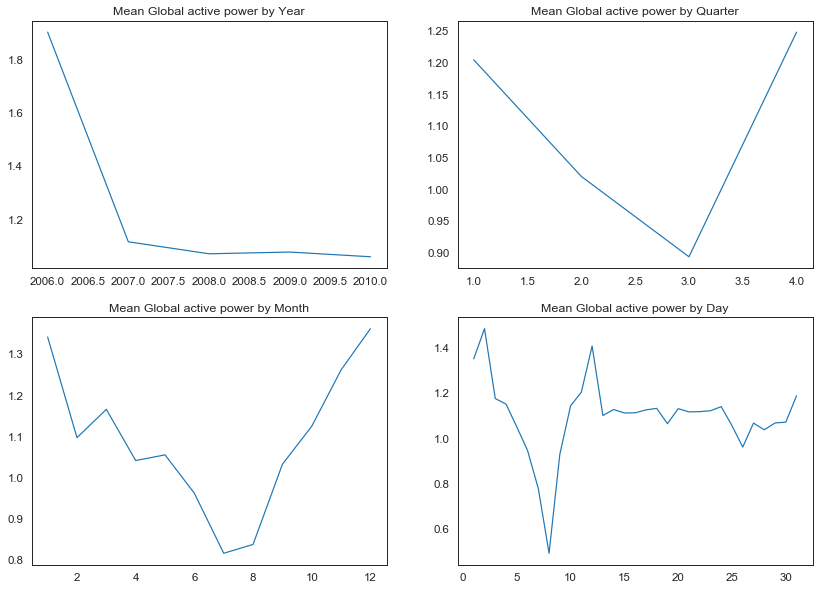

In [48]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2, 2, 2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2, 2, 3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2, 2, 4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day')

By year, it was steady.  
By quarter, the lowest average power consumption was in the 3rd quarter.  
By month, the lowest average power consumption was in July and August.  
By day, the lowest average power consumption was around 8th of the month (don’t know why).

### Global Active Power by Years

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a25d278>,
      dtype=object)

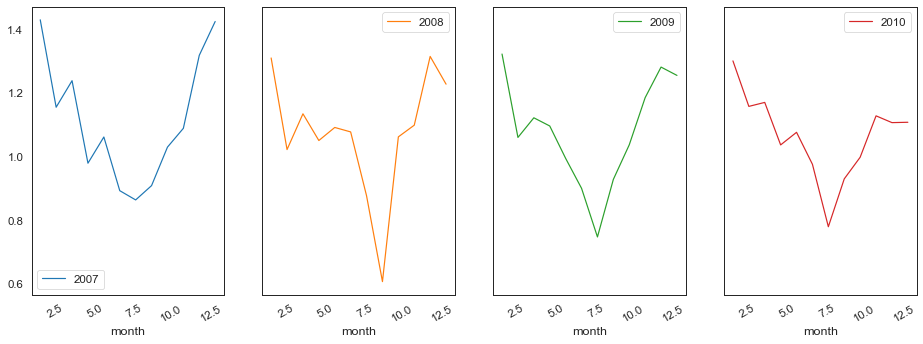

In [51]:
pd.pivot_table(df.loc[df['year'] != 2006], values='Global_active_power', columns='year',
              index='month').plot(subplots=True, figsize=(20, 20), layout=(3, 5), sharey=True)

매년 패턴이 비슷하다

### Global Active Power Consumption in Weekdays vs. Weekends

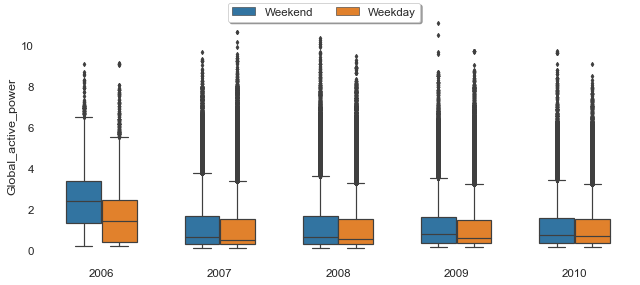

In [52]:
dic={0:'Weekend', 1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9, 4))
plt1=sns.boxplot('year', 'Global_active_power', hue='Day', width=0.6, fliersize=3, data=df)
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend().set_visible(False)

The median global active power in weekdays seems to be lower than the weekends prior to 2010. In 2010, they were identical.

### Factor Plot of Global Active Power by Weekday vs. Weekend

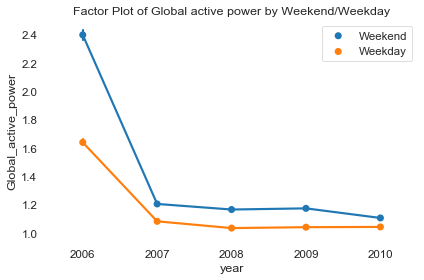

In [53]:
plt1=sns.factorplot('year', 'Global_active_power', hue='Day',
                   data=df, size=4, aspect=1.5, legend=False)
plt.title('Factor Plot of Global active power by Weekend/Weekday')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.legend(loc='upper right')

Both weekdays and weekends follow the similar pattern over year.  
In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Stationarity  
* Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller Test

* Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.  
* Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.  
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [60]:
df2 = df1.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14, 5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('<Result of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],
                      index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

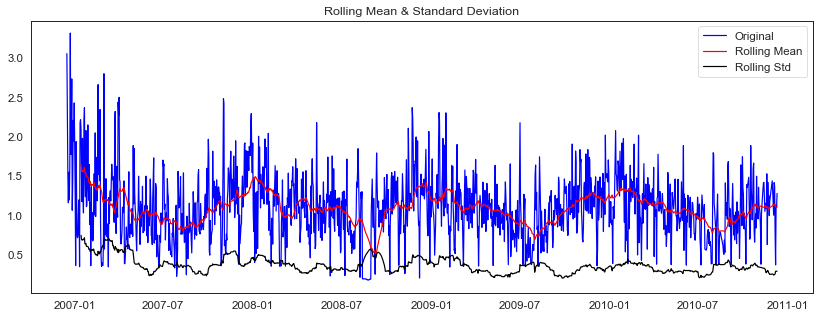

<Result of Dickey-Fuller Test>
Test Statistic                  -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of Observations Used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [61]:
test_stationarity(df2.Global_active_power.dropna())

we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

### LSTM

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.  
* Create the dataset, ensure all data is float.
* Normalize the features.
* Split into training and test sets.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features) 

In [62]:
dataset = df.Global_active_power.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size=int(len(dataset) * 0.80)
test_size=len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
        
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

* Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.  
* Dropout 20%.  
* Use the MSE loss function and the efficient Adam version of stochastic gradient descent.  
* The model will be fit for 20 training epochs with a batch size of 70.

In [64]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 73s 45us/step - loss: 7.8083e-04 - val_loss: 4.4473e-04
Epoch 2/20
1639393/1639393 [==============================] - 71s 43us/step - loss: 6.6388e-04 - val_loss: 4.4084e-04
Epoch 3/20
1639393/1639393 [==============================] - 69s 42us/step - loss: 6.5412e-04 - val_loss: 4.4454e-04
Epoch 4/20
1639393/1639393 [==============================] - 70s 42us/step - loss: 6.4763e-04 - val_loss: 4.5700e-04
Epoch 5/20
1639393/1639393 [==============================] - 69s 42us/step - loss: 6.4227e-04 - val_loss: 4.4023e-04
Epoch 6/20
1639393/1639393 [==============================] - 70s 43us/step - loss: 6.3930e-04 - val_loss: 4.3152e-04
Epoch 7/20
1639393/1639393 [==============================] - 77s 47us/step - loss: 6.3662e-04 - val_loss: 4.3377e-04
Epoch 8/20
1639393/1639393 [==============================] - 85s 52us/step - loss: 6.3427e-04 - val_loss: 4.2263e-04
Epo

### Make Predictions

In [65]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error: ', mean_absolute_error(Y_train[0], train_predict[:, 0]))
print('Train Root Mean Squared Error : ', np.sqrt(mean_squared_error(Y_train[0], train_predict[:, 0])))
print('Test Mean Absolute Error: ', mean_absolute_error(Y_test[0], test_predict[:, 0]))
print('Test Root Mean Squared Error : ', np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0])))

Train Mean Absolute Error:  0.11260180715549176
Train Root Mean Squared Error :  0.2679835347756338
Test Mean Absolute Error:  0.09852717700616946
Test Root Mean Squared Error :  0.22242827625307704


### Plot Model Loss

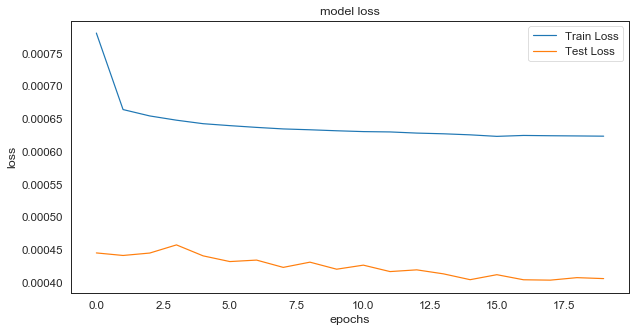

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

### Compare Actual vs. Prediction

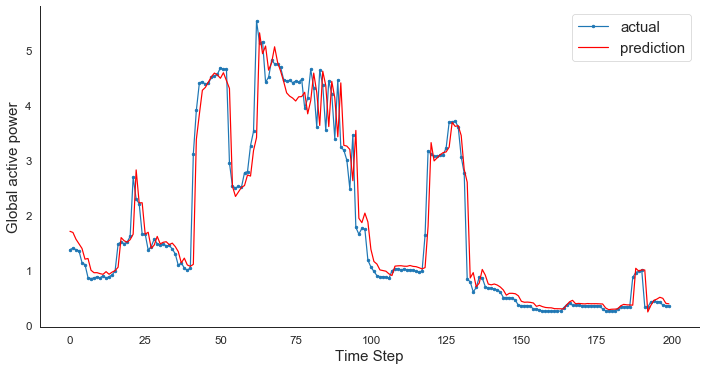

In [67]:
aa = [x for x in range(200)]
plt.figure(figsize=(10, 5))
plt.plot(aa, Y_test[0][:200], marker='.', label='actual')
plt.plot(aa, test_predict[:, 0][:200], 'r', label='prediction')
plt.tight_layout()

sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global active power', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

## 3. To Be Continue...